<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/ETF_%EB%AA%A8%EB%A9%98%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pykrx finance-datareader ta

In [6]:
import FinanceDataReader as fdr
from pykrx import stock
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import numpy as np
import datetime

In [3]:
df = fdr.StockListing('ETF/KR')

In [4]:


# 1. 운용사 필터: TIGER 또는 KODEX만 남기기
df2 = df[df["Name"].str.contains("TIGER") | df["Name"].str.contains("KODEX")]

# 2. 업종/테마 단방향 ETF만
# 예: 레버리지/인버스 제외 -> Name에 "레버리지"나 "인버스" 없는 것
df3 = df2[~df2["Name"].str.contains("레버리지|인버스", case=False)]

df3

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,360750,4,TIGER 미국S&P500,23190,2,175,0.76,23188.0,13.7104,5731385,132875,96702
1,459580,6,KODEX CD금리액티브(합성),1075155,2,75,0.01,1075180.0,0.6322,211662,227568,87644
2,069500,1,KODEX 200,48345,2,395,0.82,48366.0,18.4594,8590482,414525,82066
3,488770,7,KODEX 머니마켓액티브,103835,3,0,0.00,103847.0,0.6836,631871,65611,80846
4,133690,4,TIGER 미국나스닥100,153195,2,1240,0.82,153186.0,15.5217,330454,50609,59532
...,...,...,...,...,...,...,...,...,...,...,...,...
983,277650,2,TIGER 코스피중형주,18610,5,-55,-0.29,18637.0,9.2478,337,6,47
986,244660,2,KODEX 퀄리티Plus,9175,5,-40,-0.43,9181.0,0.2720,26,0,46
988,098560,2,TIGER 방송통신,8280,5,-35,-0.42,8292.0,-0.8940,5725,47,43
1001,404540,2,TIGER KRX기후변화솔루션,13800,2,65,0.47,13792.0,15.8876,2213,30,35


In [7]:
# === 1. 데이터 준비 ===
# df: 393개 ETF 데이터프레임
# 필수 컬럼: ['Symbol', 'Name', 'MarCap', 'Amount']
# MarCap, Amount 숫자형 변환
df3.loc[:, "MarCap"] = pd.to_numeric(df3["MarCap"], errors="coerce")
df3.loc[:, "Amount"] = pd.to_numeric(df3["Amount"], errors="coerce")

# === 2. ETF 이름 전처리 ===
stopwords = ["TIGER", "KODEX", "ETF"]  # 공통 단어 제거
def clean_name(name):
    for sw in stopwords:
        name = name.replace(sw, "")
    return name.strip()

df3.loc[:, "CleanName"] = df3["Name"].apply(clean_name)

# === 3. 텍스트 벡터화 ===
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df3["CleanName"])

# === 4. KMeans 클러스터링 ===
# 최종 목표: 대표 ETF 50~100개 → n_clusters 조정
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
df3.loc[:, "Cluster"] = kmeans.fit_predict(X)

# === 5. 클러스터별 대표 ETF 선택 ===
# 시가총액 우선, 거래대금 보조 기준
rep_etfs = (
    df3.sort_values(["Cluster", "MarCap", "Amount"], ascending=[True, False, False])
      .groupby("Cluster")
      .head(1)
      .reset_index(drop=True)
)



/tmp/ipython-input-1132428900.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, "Cluster"] = kmeans.fit_predict(X)


In [91]:
#정렬된 etfs를 바탕으로 코드 산
symbols = rep_etfs['Symbol'].tolist()

# 조회 기간: 10년=120개월
start_date = (datetime.datetime.today() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# ==============================
# 개선된 2. 가격 데이터 조회
# ==============================
all_data_list = []
for sym in symbols:
    try:
        df = fdr.DataReader(sym, start=start_date, end=end_date)[['Open', 'Close']]
        df.columns = [f'{sym}_Open', f'{sym}_Close']
        all_data_list.append(df)
    except:
        print(f"{sym} 조회 실패")

# 리스트에 있는 모든 데이터프레임을 한 번에 병합
merged_df = pd.concat(all_data_list, axis=1)

# 종가와 시가 분리
price_close = merged_df.filter(like='_Close').rename(columns=lambda x: x.replace('_Close', ''))
price_open = merged_df.filter(like='_Open').rename(columns=lambda x: x.replace('_Open', ''))

# 인덱스를 datetime으로 변환
price_close.index = pd.to_datetime(price_close.index)
price_open.index = pd.to_datetime(price_open.index)


# ==============================
# 3. 월말 종가, 월초 시가 추출
# ==============================
monthly_close = price_close.resample('ME').last()  # 월말 종가
monthly_open  = price_open.resample('MS').first()  # 월초 시가

0047A0 조회 실패
0048K0 조회 실패
0041D0 조회 실패
0086C0 조회 실패
0060H0 조회 실패
0008S0 조회 실패


In [92]:
# ==============================
# 4. N 개월 모멘텀 계산
# ==============================

holding_period = 9
returns_m = monthly_close.pct_change(periods=holding_period)


# 7~12개월 전 수익률 계산
#returns_7_12m = (monthly_close.shift(6) / monthly_close.shift(12)) - 1

In [93]:
# ==============================
# 5. 포트폴리오 백테스트 (Top2 1개월 보유)
# ==============================
initial_capital = 1_000_000_000
portfolio_value = pd.Series(initial_capital, index=monthly_close.index)


top_n = 2  # 상위 n개 종목 선정 (2,3,4 등 자유롭게 변경 가능)

# 상위 n종목 기록용 DataFrame
cols = ['Top' + str(i+1) for i in range(top_n)]
cols += ['Top' + str(i+1) + '_Name' for i in range(top_n)]
cols += ['Top' + str(i+1) + '_Return' for i in range(top_n)]
top_record = pd.DataFrame(index=monthly_close.index, columns=cols)

# Symbol → 이름 매핑
symbol_to_name = rep_etfs.set_index('Symbol')['CleanName']

for i in range(len(monthly_close) - 1):
    prev_returns = returns_m.iloc[i].dropna()
    top_symbols = prev_returns.nlargest(top_n).index

    # 선택 종목 기록
    for j in range(top_n):
        top_record.iloc[i, j] = top_symbols[j] if j < len(top_symbols) else None
        top_record.iloc[i, top_n + j] = symbol_to_name.get(top_symbols[j]) if j < len(top_symbols) else None

    if len(top_symbols) == 0:
        portfolio_value.iloc[i + 1] = portfolio_value.iloc[i]
        continue

    # 익월 초 시가 매수 → 익월말 종가 매도 수익률
    current_open = monthly_open.iloc[i + 1][top_symbols]
    next_close   = monthly_close.iloc[i + 1][top_symbols]
    next_returns = (next_close / current_open - 1)

    # 수익률 기록
    for j in range(top_n):
        top_record.iloc[i, 2*top_n + j] = next_returns.iloc[j] if j < len(next_returns) else None

    # 포트폴리오 업데이트 (Equal weight)
    portfolio_return = next_returns.mean(skipna=True)
    portfolio_value.iloc[i + 1] = portfolio_value.iloc[i] * (1 + portfolio_return)

    cum_returns = portfolio_value / initial_capital - 1

/tmp/ipython-input-1017033205.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '911156656.5465271' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_value.iloc[i + 1] = portfolio_value.iloc[i] * (1 + portfolio_return)


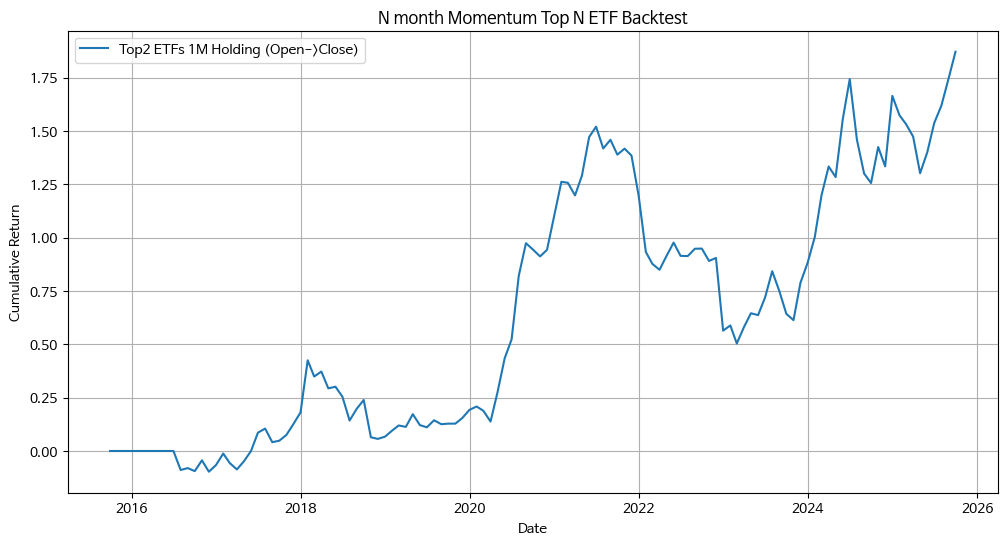

In [94]:
import matplotlib.pyplot as plt

# ==============================
# 7. 결과 확인
# ==============================
plt.figure(figsize=(12,6))
plt.plot(cum_returns.index, cum_returns.values, label="Top2 ETFs 1M Holding (Open->Close)")
plt.title("N month Momentum Top N ETF Backtest")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()